In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("/content/drive/MyDrive/研究/牛/20240908_cow_心拍と皮筋振動の分離/2023-09-20-6-reiwa.csv")
TIMEEVENT = df["TimeEvent"]
TIMEEVENT.dropna(inplace=True)
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308526 entries, 0 to 308525
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   TimeAnalog  308526 non-null  float64
 1   EMG         308526 non-null  float64
 2   EMG.1       308526 non-null  float64
 3   Raw         308526 non-null  float64
 4   ECG         308526 non-null  float64
 5   TimeEvent   411 non-null     float64
 6   Event       411 non-null     float64
dtypes: float64(7)
memory usage: 16.5 MB


,TimeAnalog,EMG,EMG.1,Raw,ECG,TimeEvent,Event
0,0.000,-743.241273,-371.230697,-77.538500,-87.191238,68.558,2000.0
1,0.002,-258.447627,-135.680825,-72.626599,-78.560583,69.184,2000.0
2,0.004,5.853382,65.819611,-67.740448,-63.496943,70.120,2000.0
3,0.006,-14.228791,254.221047,-62.911995,-44.361394,71.246,2000.0
4,0.008,-60.786241,468.807729,-58.152206,-23.371174,72.146,2000.0
5,0.010,-254.967734,652.488897,-53.468711,-3.228661,73.090,2000.0
6,0.012,-379.719825,755.559793,-48.850065,10.887999,74.212,2000.0
7,0.014,-569.532897,739.238916,-44.308668,12.105647,78.088,2000.0
8,0.016,-661.621845,679.262998,-39.846425,-0.045526,78.758,2000.0
9,0.018,-779.876181,620.548668,-35.486226,-11.167585,79.338,2000.0


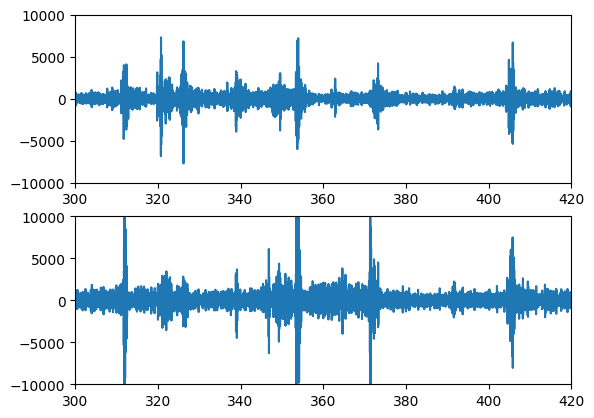

In [ ]:
plt.figure()
plt.subplot(211)
plt.plot(df["TimeAnalog"], df["EMG"])
plt.xlim(300, 420)
plt.ylim(-10000, 10000)

plt.subplot(212)
plt.plot(df["TimeAnalog"], df["EMG.1"])
plt.xlim(300, 420)
plt.ylim(-10000, 10000)
plt.show()

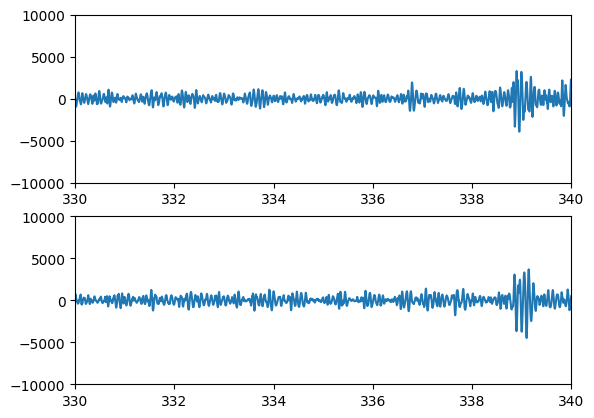

In [ ]:
plt.figure()
plt.subplot(211)
plt.plot(df["TimeAnalog"], df["EMG"])
plt.xlim(330, 340)
plt.ylim(-10000, 10000)

plt.subplot(212)
plt.plot(df["TimeAnalog"], df["EMG.1"])
plt.xlim(330, 340)
plt.ylim(-10000, 10000)
plt.show()

## ICAによる心拍と体表振動の分離

          EMG       EMG.1  ICA_Component_1  ICA_Component_2
0 -743.241273 -371.230697         0.836831        -0.202740
1 -258.447627 -135.680825         0.290811        -0.073864
2    5.853382   65.819611        -0.005036         0.033665
3  -14.228791  254.221047         0.022554         0.129379
4  -60.786241  468.807729         0.080943         0.237968


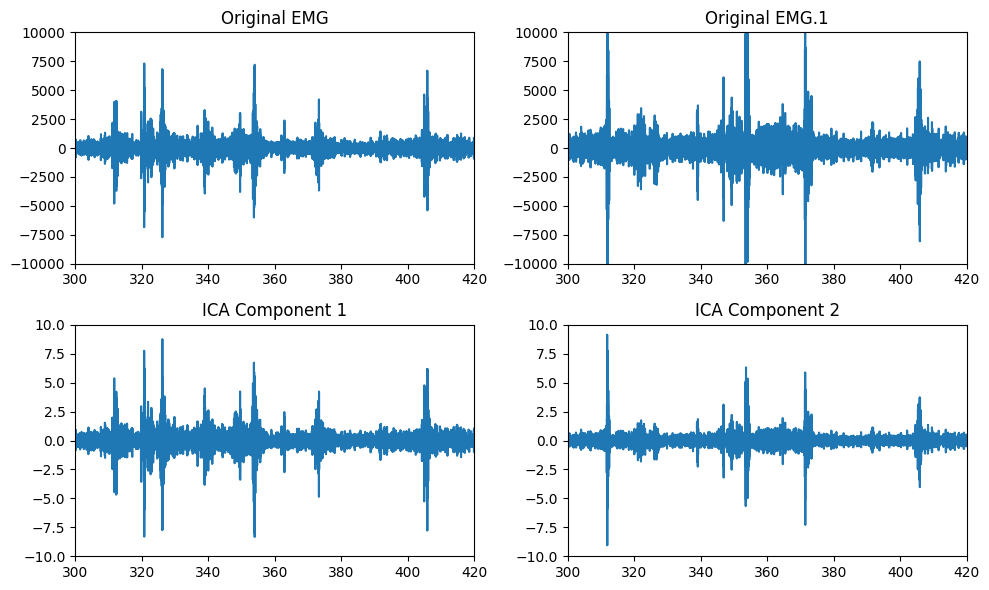

In [ ]:
# prompt: dfのEMGとEMG.1カラムをICAで分離

import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

# ICAを適用するデータの選択
X = df[['EMG', 'EMG.1']].values

# ICAオブジェクトの作成
ica = FastICA(n_components=2)

# ICAによる分離
components = ica.fit_transform(X)

# 分離された成分をデータフレームに追加
df['ICA_Component_1'] = components[:, 0]
df['ICA_Component_2'] = components[:, 1]

# 結果の確認
print(df[['EMG', 'EMG.1', 'ICA_Component_1', 'ICA_Component_2']].head())

# 分離された成分のプロット
plt.figure(figsize=(10, 6))
plt.subplot(221)
plt.plot(df["TimeAnalog"], df["EMG"])
plt.xlim(300, 420)
plt.ylim(-10000, 10000)
plt.title('Original EMG')

plt.subplot(222)
plt.plot(df["TimeAnalog"], df["EMG.1"])
plt.xlim(300, 420)
plt.ylim(-10000, 10000)
plt.title('Original EMG.1')

plt.subplot(223)
plt.plot(df["TimeAnalog"], df["ICA_Component_1"])
plt.xlim(300, 420)
plt.ylim(-10, 10)
plt.title('ICA Component 1')

plt.subplot(224)
plt.plot(df["TimeAnalog"], df["ICA_Component_2"])
plt.xlim(300, 420)
plt.ylim(-10, 10)
plt.title('ICA Component 2')

plt.tight_layout()
plt.show()


ICAはうまくノイズと心拍を分離できていなさそう \
- 二つのBCGで場所が違うからノイズの類似性が低い？

## 周波数解析

In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 48.2 MB/s eta 0:00:00


In [ ]:
# ダウンサンプリング
from scipy import stats
df_std = stats.zscore(df)
df_downsampled = df_std[::10].reset_index(drop=True)

In [ ]:
# prompt: 連続ウェーブレット変換

import numpy as np
import pywt

def cwt(data, scales):
  """
  Performs continuous wavelet transform on the given data.

  Args:
    data: A NumPy array containing the data to be transformed.
    scales: A list of scales to use for the transform.

  Returns:
    A NumPy array containing the wavelet coefficients.
  """

  wavelet = pywt.ContinuousWavelet('morl')
  coefficients, _ = pywt.cwt(data, scales, wavelet)

  return coefficients

# cwt_coefficients = cwt(df_downsampled["EMG"], scales=np.arange(1, 32))
cwt_coefficients = cwt(df["EMG"], scales=np.arange(1, 64))
cwt_coefficients.shape

(63, 308526)

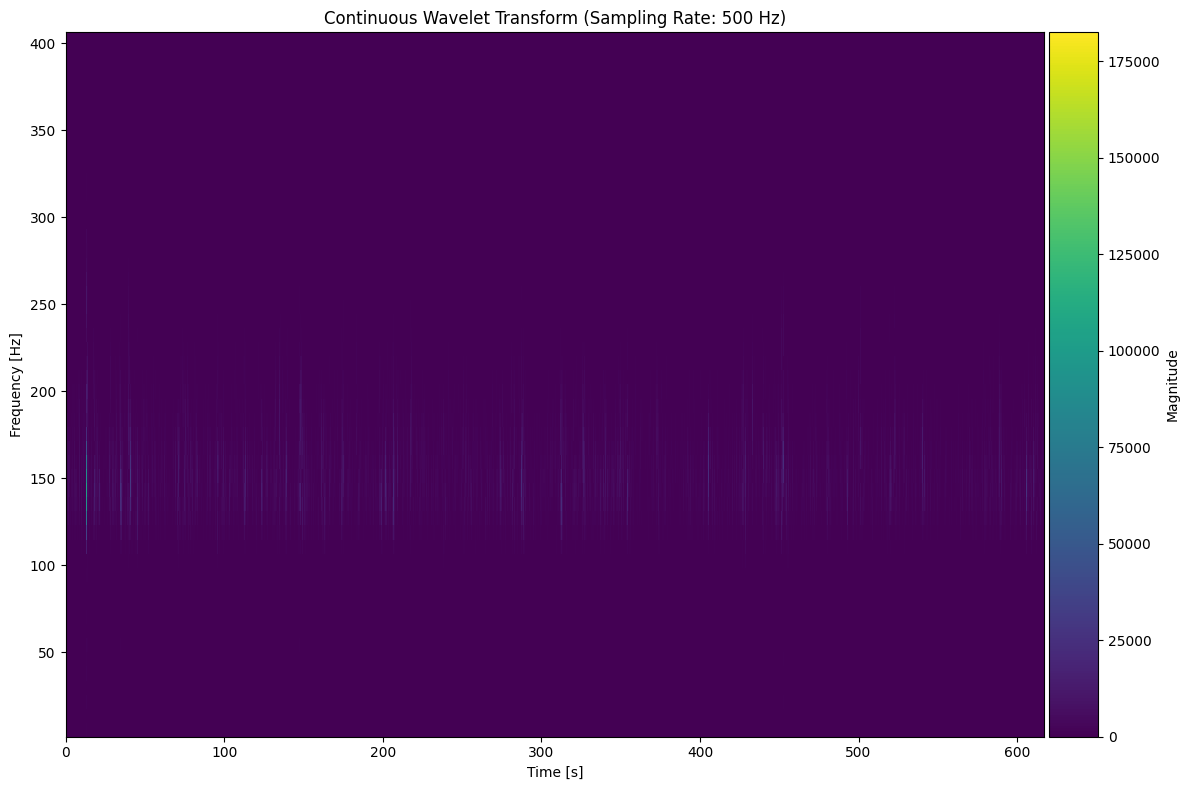

Full signal duration: 617.05 seconds
Frequency range: 1.59 Hz to 406.25 Hz
Number of time points: 308526
Number of frequency bins: 50


array([[  60.93021025,  124.06291625,  -58.65251498, ...,   -1.16517491,
          -4.58382382,  -71.23828369],
       [ 112.40821083,  -98.23360949,  -15.81653647, ...,   10.9134039 ,
         -75.28948875,    6.67943005],
       [  -0.50030207,  129.35372576,  -93.29308435, ...,   -6.72644881,
          33.10627792,  -43.95420479],
       ...,
       [-211.51814593, -128.01805433, -213.2866472 , ..., -245.79729404,
        -210.08785429, -299.00586973],
       [-156.28700248,  -29.10057478, -228.16686074, ..., -194.79066258,
        -139.4606065 , -223.88273386],
       [-112.46953988, -152.83714376,  -47.30821221, ..., -166.38474542,
        -275.3349262 , -253.91565388]])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pywt

def plot_cwt(time, frequencies, cwt_coefficients, title="Continuous Wavelet Transform",
             time_range=None):
    plt.figure(figsize=(12, 8))

    if time_range is None:
        time_range = (time[0], time[-1])

    # Find indices corresponding to the specified time range
    start_idx = np.searchsorted(time, time_range[0])
    end_idx = np.searchsorted(time, time_range[1])

    # cwt_coefficients = cwt_coefficients[::-1, :]
    # Slice the data for the specified time range
    time_slice = time[start_idx:end_idx]
    coef_slice = cwt_coefficients[:, start_idx:end_idx]

    im = plt.imshow(np.abs(coef_slice),
                    extent=[time_slice[0], time_slice[-1], frequencies[-1], frequencies[0]],
                    aspect='auto',
                    interpolation='nearest',
                    cmap='viridis')

    plt.title(title)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax, label='Magnitude')

    plt.tight_layout()
    plt.show()

def perform_cwt_analysis(data, sampling_rate, min_scale=1, max_scale=256, num_scales=50,
                         time_range=None):
    """
    Performs CWT analysis and visualization.

    Args:
        data: Input signal
        sampling_rate: Sampling rate of the signal in Hz
        min_scale: Minimum scale for CWT
        max_scale: Maximum scale for CWT
        num_scales: Number of scales to use
        time_range: Tuple of (start_time, end_time) for zoomed view. If None, show full range.
    """
    # Calculate scales using a logarithmic distribution
    # scales = np.linspace(min_scale, max_scale, num=num_scales)

    # 対数スケール
    scales = np.logspace(np.log10(min_scale), np.log10(max_scale), num=num_scales)

    # Perform CWT
    wavelet = pywt.ContinuousWavelet('morl')
    cwt_coefficients, _ = pywt.cwt(data, scales, wavelet)

    # Calculate time and frequency arrays
    time = np.arange(len(data)) / sampling_rate
    frequencies = pywt.scale2frequency('morl', scales) * sampling_rate

    # Plot the CWT
    plot_cwt(time, frequencies, cwt_coefficients,
             f"Continuous Wavelet Transform (Sampling Rate: {sampling_rate} Hz)",
             time_range=time_range)

    # Print analysis information
    if time_range:
        print(f"Displayed time range: {time_range[0]:.2f} to {time_range[1]:.2f} seconds")
    else:
        print(f"Full signal duration: {time[-1]:.2f} seconds")
    print(f"Frequency range: {frequencies[-1]:.2f} Hz to {frequencies[0]:.2f} Hz")
    print(f"Number of time points: {len(data)}")
    print(f"Number of frequency bins: {len(scales)}")

    return cwt_coefficients

# Example usage
sampling_rate = 500  # Hz

# Full range view
perform_cwt_analysis(df["EMG"], sampling_rate, min_scale=1, max_scale=256, num_scales=50)

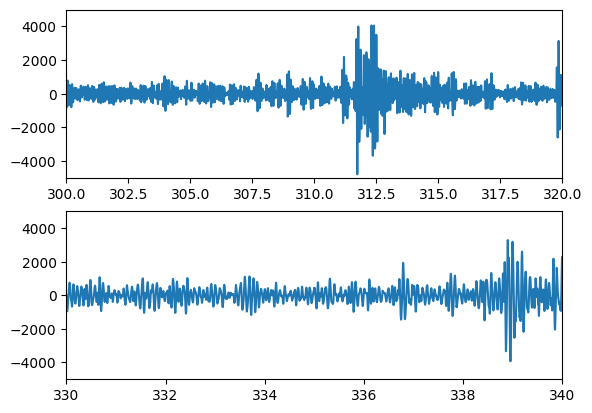

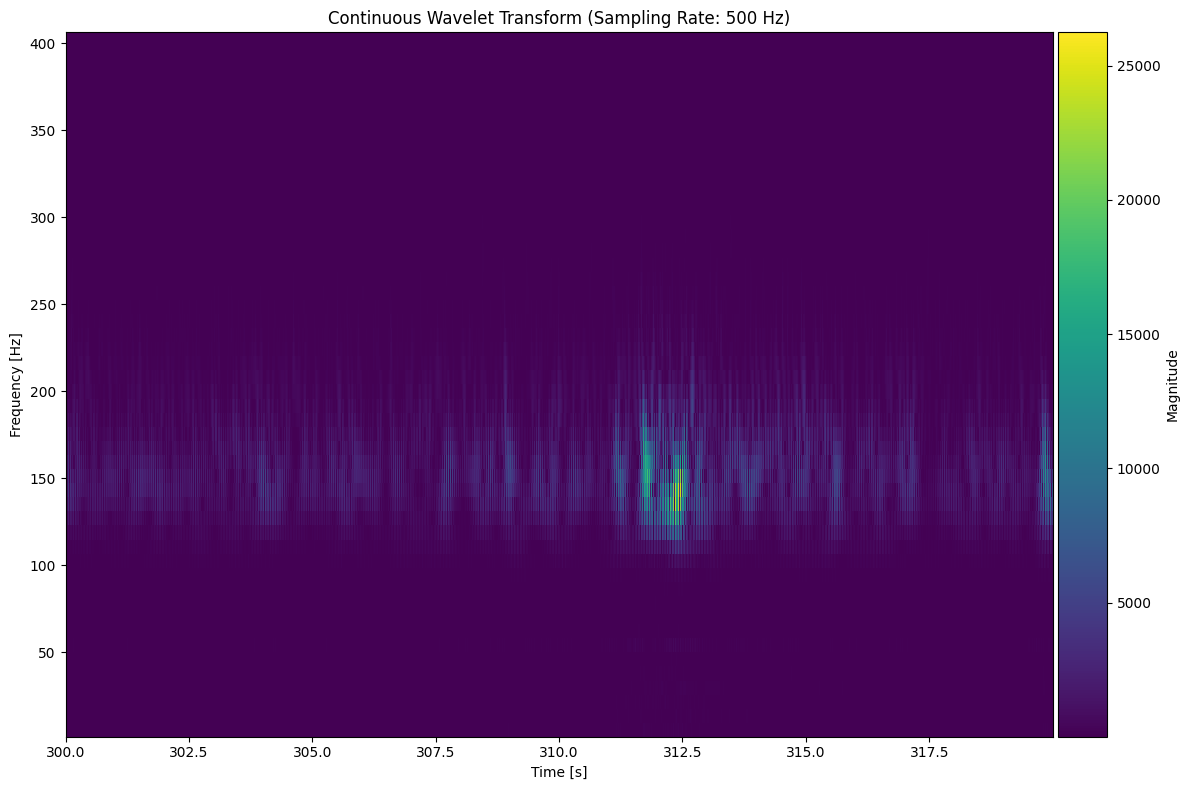

Displayed time range: 300.00 to 320.00 seconds
Frequency range: 1.59 Hz to 406.25 Hz
Number of time points: 308526
Number of frequency bins: 50


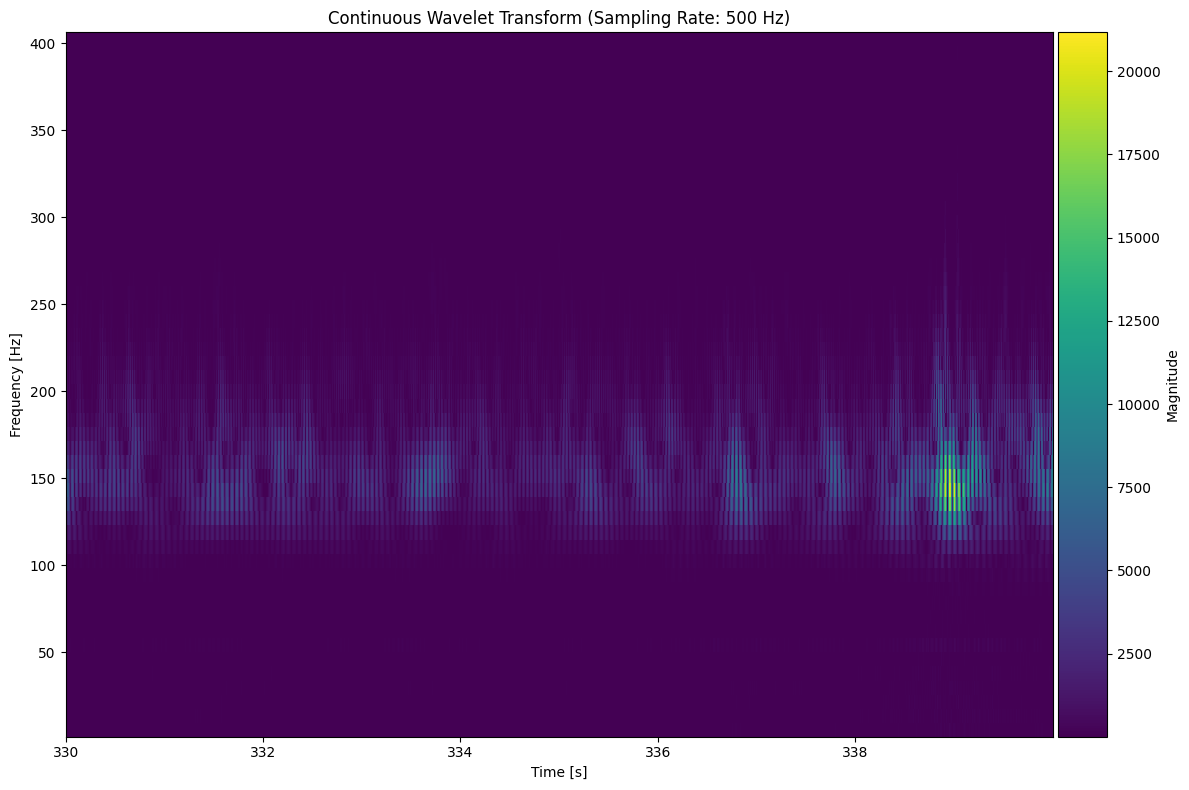

Displayed time range: 330.00 to 340.00 seconds
Frequency range: 1.59 Hz to 406.25 Hz
Number of time points: 308526
Number of frequency bins: 50


In [ ]:
plt.figure()
plt.subplot(211)
plt.plot(df["TimeAnalog"], df["EMG"])
plt.xlim(300, 320)
plt.ylim(-5000, 5000)

plt.subplot(212)
plt.plot(df["TimeAnalog"], df["EMG"])
plt.xlim(330, 340)
plt.ylim(-5000, 5000)
plt.show()

# Zoomed view (e.g., from 10 to 20 seconds)
cwt_coefficients = perform_cwt_analysis(df["EMG"], sampling_rate, min_scale=1, max_scale=256, num_scales=50,
                     time_range=(300, 320))
# Zoomed view (e.g., from 10 to 20 seconds)
cwt_coefficients = perform_cwt_analysis(df["EMG"], sampling_rate, min_scale=1, max_scale=256, num_scales=50,
                     time_range=(330, 340))

## CNN

In [ ]:
import os
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Reshape, Conv1D, BatchNormalization, Activation, AveragePooling1D, GlobalAveragePooling1D, Lambda, Input, Concatenate, Add, UpSampling1D, Multiply
from tensorflow.keras.models import Model
# from tensorflow.keras.objectives import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.initializers import random_normal
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import Callback

from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.model_selection import KFold, train_test_split

In [ ]:
train_input = df_train["signal"].values.reshape(-1,4000,1)#number_of_data:1250 x time_step:4000
train_input_mean = train_input.mean()
train_input_sigma = train_input.std()
train_input = (train_input-train_input_mean)/train_input_sigma
test_input = df_test["signal"].values.reshape(-1,10000,1)#
test_input = (test_input-train_input_mean)/train_input_sigma

#train_target = df_train["open_channels"].values.reshape(-1,4000,1)#regression
train_target = pd.get_dummies(df["open_channels"]).values.reshape(-1,4000,11)#classification

idx = np.arange(train_input.shape[0])
train_idx, val_idx = train_test_split(idx, random_state = 111,test_size = 0.2)

val_input = train_input[val_idx]
train_input = train_input[train_idx]
val_target = train_target[val_idx]
train_target = train_target[train_idx]

print("train_input:{}, val_input:{}, train_target:{}, val_target:{}".format(train_input.shape, val_input.shape, train_target.shape, val_target.shape))

In [ ]:
def cbr(x, out_layer, kernel, stride, dilation):
    x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def se_block(x_in, layer_n):
    x = GlobalAveragePooling1D()(x_in)
    x = Dense(layer_n//8, activation="relu")(x)
    x = Dense(layer_n, activation="sigmoid")(x)
    x_out=Multiply()([x_in, x])
    return x_out

def resblock(x_in, layer_n, kernel, dilation, use_se=True):
    x = cbr(x_in, layer_n, kernel, 1, dilation)
    x = cbr(x, layer_n, kernel, 1, dilation)
    if use_se:
        x = se_block(x, layer_n)
    x = Add()([x_in, x])
    return x

def Unet(input_shape=(None,1)):
    layer_n = 64
    kernel_size = 7
    depth = 2

    input_layer = Input(input_shape)
    input_layer_1 = AveragePooling1D(5)(input_layer)
    input_layer_2 = AveragePooling1D(25)(input_layer)

    ########## Encoder
    x = cbr(input_layer, layer_n, kernel_size, 1, 1)#1000
    for i in range(depth):
        x = resblock(x, layer_n, kernel_size, 1)
    out_0 = x

    x = cbr(x, layer_n*2, kernel_size, 5, 1)
    for i in range(depth):
        x = resblock(x, layer_n*2, kernel_size, 1)
    out_1 = x

    x = Concatenate()([x, input_layer_1])
    x = cbr(x, layer_n*3, kernel_size, 5, 1)
    for i in range(depth):
        x = resblock(x, layer_n*3, kernel_size, 1)
    out_2 = x

    x = Concatenate()([x, input_layer_2])
    x = cbr(x, layer_n*4, kernel_size, 5, 1)
    for i in range(depth):
        x = resblock(x, layer_n*4, kernel_size, 1)

    ########### Decoder
    x = UpSampling1D(5)(x)
    x = Concatenate()([x, out_2])
    x = cbr(x, layer_n*3, kernel_size, 1, 1)

    x = UpSampling1D(5)(x)
    x = Concatenate()([x, out_1])
    x = cbr(x, layer_n*2, kernel_size, 1, 1)

    x = UpSampling1D(5)(x)
    x = Concatenate()([x, out_0])
    x = cbr(x, layer_n, kernel_size, 1, 1)

    #regressor
    #x = Conv1D(1, kernel_size=kernel_size, strides=1, padding="same")(x)
    #out = Activation("sigmoid")(x)
    #out = Lambda(lambda x: 12*x)(out)

    #classifier
    x = Conv1D(11, kernel_size=kernel_size, strides=1, padding="same")(x)
    out = Activation("softmax")(x)

    model = Model(input_layer, out)

    return model


def augmentations(input_data, target_data):
    #flip
    if np.random.rand()<0.5:
        input_data = input_data[::-1]
        target_data = target_data[::-1]

    return input_data, target_data


def Datagen(input_dataset, target_dataset, batch_size, is_train=False):
    x=[]
    y=[]

    count=0
    idx_1 = np.arange(len(input_dataset))
    #idx_2 = np.arange(len(input_dataset))
    np.random.shuffle(idx_1)
    #np.random.shuffle(idx_2)

    while True:
        for i in range(len(input_dataset)):
            input_data = input_dataset[idx_1[i]]
            target_data = target_dataset[idx_1[i]]
            #input_data_mix = input_dataset[idx_2[i]]
            #target_data_mix = target_dataset[idx_2[i]]

            if is_train:
                input_data, target_data = augmentations(input_data, target_data)
                #input_data_mix, target_data_mix = augmentations(input_data_mix, target_data_mix)

            x.append(input_data)
            y.append(target_data)
            count+=1
            if count==batch_size:
                x=np.array(x, dtype=np.float32)
                y=np.array(y, dtype=np.float32)
                inputs = x
                targets = y
                x = []
                y = []
                count=0
                yield inputs, targets

class macroF1(Callback):
    def __init__(self, model, inputs, targets):
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis=2).reshape(-1)

    def on_epoch_end(self, epoch, logs):
        pred = np.argmax(self.model.predict(self.inputs), axis=2).reshape(-1)
        f1_val = f1_score(self.targets, pred, average="macro")
        print("val_f1_macro_score: ", f1_val)

def model_fit(model, train_inputs, train_targets, val_inputs, val_targets, n_epoch, batch_size=32):
    hist = model.fit_generator(
        Datagen(train_inputs, train_targets, batch_size, is_train=True),
        steps_per_epoch = len(train_inputs) // batch_size,
        epochs = n_epoch,
        validation_data=Datagen(val_inputs, val_targets, batch_size),
        validation_steps = len(val_inputs) // batch_size,
        callbacks = [lr_schedule, macroF1(model, val_inputs, val_targets)],
        shuffle = False,
        verbose = 1
        )
    return hist


def lrs(epoch):
    if epoch<35:
        lr = learning_rate
    elif epoch<50:
        lr = learning_rate/10
    else:
        lr = learning_rate/100
    return lr

In [ ]:
K.clear_session()
model = Unet()
#print(model.summary())

learning_rate=0.0005
n_epoch=60
batch_size=32

lr_schedule = LearningRateScheduler(lrs)

#regressor
#model.compile(loss="mean_squared_error",
#              optimizer=Adam(lr=learning_rate),
#              metrics=["mean_absolute_error"])

#classifier
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=learning_rate),
              metrics=["accuracy"])

hist = model_fit(model, train_input, train_target, val_input, val_target, n_epoch, batch_size)

## 異常検知

In [ ]:
# wandb ログイン
import wandb
from google.colab import userdata
wandb_api_key = userdata.get('WANDB_API_KEY')
!wandb login $wandb_api_key

### LSTM

In [3]:
def generator(data, lookback, delay, pred_length, min_index, max_index, shuffle=False,
              batch_size=100, step=1):
    if max_index is None:
        max_index = len(data) - delay - pred_length - 1
    i = min_index + lookback

    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index,
                                    size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                               lookback//step,
                               data.shape[-1]))

        targets = np.zeros((len(rows), pred_length))

        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay : rows[j] + delay + pred_length].flatten()

        yield samples, targets


In [9]:
lookback = 500
pred_length = 50 # 2.0s * 500Hz
step = 1
delay = 1
batch_size = 200

normal_cycle = df["EMG"][10000:].values
normal_cycle = normal_cycle.reshape(-1, 1)

# 訓練ジェネレータ
train_gen = generator(normal_cycle,
                     lookback=lookback,
                     pred_length=pred_length,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

val_gen = generator(normal_cycle,
                   lookback=lookback,
                   pred_length=pred_length,
                   delay=delay,
                   min_index=200001,
                   max_index=290000,
                   step=step,
                   batch_size=batch_size)


# 検証データセット全体を調べるためにval_genから抽出する時間刻みの数
val_steps = (290000 - 200001 -lookback) // batch_size

# その他は、テストデータ


In [8]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.4 MB/s eta 0:00:00


In [ ]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import wandb
from wandb.integration.keras import WandbMetricsLogger


wandb.init(project="cow_HeartRate_and_Breath")

# モデルの構築
model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(None,normal_cycle.shape[-1])))
model.add(layers.LSTM(32))
model.add(layers.Dense(pred_length))

model.compile(optimizer=RMSprop(), loss="mse")

history = model.fit(train_gen,
                    steps_per_epoch=200,
                    epochs=60,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    callbacks=[WandbMetricsLogger()])

wandb.finish()

Epoch 1/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - loss: 674903.6250 - val_loss: 415491.6875
Epoch 2/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - loss: 624480.8750 - val_loss: 413771.5000
Epoch 3/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - loss: 581470.6875 - val_loss: 412101.6250
Epoch 4/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - loss: 682272.5000 - val_loss: 410409.9062
Epoch 5/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - loss: 633718.5625 - val_loss: 408757.3750
Epoch 6/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - loss: 589647.3750 - val_loss: 407086.0000
Epoch 7/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - loss: 626325.1250 - val_loss: 405469.6250
Epoch 8/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - loss: 656217.6250 - val_loss: 403864.5000
Epoch 9/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - loss: 620730.5000 - val_loss: 402175.0938
Epoch 10/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - loss: 617050.4375 - val_loss: 400487.1875
Epoch 11/

epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,▇█▇▆▇▇▇█▆▆▇▅▅▅▄▆▅▅▅▅▆▄▅▅▃▄▄▄▂▅▃▃▄▃▃▃▁▁▃▂
epoch/val_loss,███▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch/epoch,59
epoch/learning_rate,0.001
epoch/loss,526104.75
epoch/val_loss,342517.5625


In [ ]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint


wandb.init(project="cow_HeartRate_and_Breath",
           name="experiment-3",
           config={"epochs": 500})

# モデルの構築
model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(None,normal_cycle.shape[-1])))
model.add(layers.LSTM(32))
model.add(layers.Dense(pred_length))

model.compile(optimizer=RMSprop(), loss="mse")

history = model.fit(train_gen,
                    steps_per_epoch=200,
                    epochs=500,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    callbacks=[WandbMetricsLogger(),
                               WandbModelCheckpoint("models.keras")])

wandb.finish()

Epoch 1/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - loss: 612363.6250 - val_loss: 415495.5312
Epoch 2/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - loss: 640652.1875 - val_loss: 413757.5000
Epoch 3/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - loss: 610679.1250 - val_loss: 412095.0312
Epoch 4/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - loss: 640891.2500 - val_loss: 410781.3438
Epoch 5/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - loss: 651607.9375 - val_loss: 408714.7812
Epoch 6/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - loss: 641566.0000 - val_loss: 406994.7188
Epoch 7/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - loss: 613620.4375 - val_loss: 405293.5625
Epoch 8/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - loss: 611760.4375 - val_loss: 403555.5000
Epoch 9/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - loss: 633808.8125 - val_loss: 401833.9062
Epoch 10/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - loss: 599449.3750 - val_loss: 400328.5938
Epoch 11/

In [ ]:
wandb.init(project="cow_HeartRate_and_Breath",
           config={"epochs": 500})


history = model.fit(train_gen,
                    steps_per_epoch=200,
                    epochs=500,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    callbacks=[WandbMetricsLogger()])

wandb.finish()

In [ ]:
history.save("/content/drive/MyDrive/研究/牛/20240908_cow_心拍と皮筋振動の分離/my_model")

NameError: name 'history' is not defined